# Convolutional Neural Network for MNIST classification

Dataset: http://yann.lecun.com/exdb/mnist/

![alt text](http://rodrigob.github.io/are_we_there_yet/build/images/mnist.png?1363085077 "MNIST Dataset Example")

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

### A Filter is a matrix of number. This is what it looks like:
![alt text](https://adeshpande3.github.io/assets/Filter.png "CNN Filter")

### The following diagrams shows roughly how the data flows in a CNN
![alt text](CNNDiagram.JPG "MNIST Dataset Example")

The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The images are also down-sampled so the image resolution is decreased from 28x28 to 14x14.

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are down-sampled again to 7x7 pixels.

The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons (or elements). This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured as the so-called cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

# Configuration of Neural Network
When dealing with inputs such as images, it is impractical to connect neurons to all neurons in the previous volume. Instead, we will connect each neuron to only a local region of the input volume. The spatial extent of this connectivity is a hyperparameter called receptive field of the neuron (equivalent to the filter size). 

In [2]:
#Convolution layer 1
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)

# Defining Data Dimensions

We use these data dimensions in several places in the code below. We'll define them here so that we can use the variables in the code rather than numbers.

In [6]:
# MNIST images are 28 pixels in each dimension
img_size = 28

# Images are stored in one dimensional arrays of this length
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel since the MNIST dataset is grey-scale
# Channels mean the number of primary colours. If this were a coloured dataset, we'd have 3 channels (RGB)
num_channels = 1

# Number of classes. Since there are 10 digits, then there are 10 classes
num_classes = 10

### Plotting thee images
In order to plot the images, we will use a 3x3 grid. We will write the true and predicted classes below each image.

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        # Show the classes as the label on the axis
        ax.set_xlabel(xlabel)
        
        # Remove the ticks from the plots
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Show the plot
    plt.show()

### Plot some images to test the function

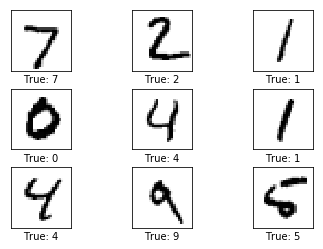

In [8]:
# Get the first images from the test-set
images = data.test.images[0:9]

# Get the true classes for those images
cls_true = data.test.cls[0:9]

# Plot the images and labels using our plot_images function
plot_images(images=images, cls_true=cls_true)

### Tensorflow is much more efficient than numpy because of its ability to run computations in parallel

Tensorflow is more efficient because it knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

Tensorflow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

A Tensorflow graph consists of the following parts:
- Placeholder variables used for inputting data to the graph
- Variables that are going to be optimized so as to make the convolutional network perform better
- The mathematical formulas for the convolutional network
- A cost measure that can be used to guide the optimization of the variables
- An optimization method which updates the variables

# Helper Functions

### HF's for creating new variables
Functions for creating new Tensorflow variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the Tensorflow graph.

In [9]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [10]:
def new_biases(length):
    # equivalent to the y-intercept in y = mx + b
    # constant value carried over across matrix math
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer

This HP will create a new convolutional layer in the computation graph for Tensorflow. We aren't doing any calculations here, we are only adding the mathematical functions to the Tensorflow graph.

We are going to assume that the input is a 4-dimension tensor with the following dimensions:
1. Image number
2. Y-axis 
3. X-axis
4. Channels

Remember that the input channels may either be colour-channels, OR it may be filter-channels if the input is produced from a previous convolutional layer.

The output is another 4-dimension tensor with the following dimensions:
1. Image number, same as input
2. Y-axis. If 2x2 pooling is used, then the height and width of the input images is divided by 2
3. X-axis. Same as above
4. Channels produced by the convolutional filters

In [11]:
def new_conv_layer(input,              # The previous layer
                  num_input_channels,  # Num. channels in prev. layer
                  filter_size,         # Width and height of each filter
                  num_filters,         # Number of filters
                  use_pooling=True):   # Use 2x2 max-pooling
    
    # Shape of the filter-weidhts for the convolution
    # This format is determined by the Tensorflow API
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    # Create new weights aka. filters with the given shape
    weights = new_weights(shape=shape)
    
    # Create new biases, one for each filter
    biases = new_biases(length=num_filters)
    
    # Create the Tensorflow operation for convolution. 
    # Note that the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1, because
    # the first is for the image-number and the last is for 
    # the input-channel.
    # But e.g. strides=[1,2,2,1] would mean that the filter is 
    # moved 2 pixels across the x and y-axis of the image.
    # The padding is set to 'SAME', which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    
    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases
    
    # Use pooling to down-sample the image resolution
    if use_pooling:
        # This is 2x2 max-pooling, which means that we consider
        # 2x2 windows and select the largest value in each window.
        # Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding='SAME')
    
    # Rectified Linear Unit (ReLU)
    # It calculates the max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)
    
    # Note: ReLU is normally executed before the pooling, but since
    # relu(max_pool(x)) == max_pool(relu(x)), we can save 75% of the 
    # relu operations by max-pooling first
    
    # We return both the resulting layer and the filter-weights 
    # because we will plot the weights later
    return layer, weights

### Helper-function for flattening a layer

A convolutional layer produced an output tensor with 4-dimensions. We will add fully-connected layers after the convolution layer, so we need to reduce the 4-dimension tensor to 2-dimension. The 2-dimension tensor can be used as input to the fully-connected layer. 
![alt text](https://www.superdatascience.com/wp-content/uploads/2018/08/CNN_Step3_Img1.png "Flattening a layer")


In [12]:
def flatten_layer(layer):
    # Get the shape of the input layer
    layer_shape = layer.get_shape()
    
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]
    
    # The number of features is: img_height * img_width * num_channels
    # We can use a function from Tensorflow to calculate this
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features]
    # Note: We just set the size of the second dimension to
    # num_features and the size of the first dimension to -1,
    # which means the size in that dimension is calculated so that 
    # the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]
    
    # Return both the flattened layer and the number of features
    return layer_flat, num_features

### Helper-function for creating a Fully-Connected Layer

This HP will create a new full-connected layer in the computational graph for Tensorflow. We are not doing any calculations here, we are just adfing the mathematical formulas to the Tensorflow graph.

It is assumed that the input is a 2-dimension tensor of shape [num_images, num_inputs]. The output is a 2-dimension tensor of a shape [num_images, num_outputs]

In [40]:
def new_fc_layer(input,            # The previous layer
                num_inputs,        # Num. inputs from the prev. layer
                num_outputs,       # Num. outputs
                use_relu=True):    # Use Rectified Linear Unit (ReLU)?
    
    # Create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    # Calculate the layer as the matrix multiplication of the
    # input and weidhts, and then add the bias-values
    layer = tf.matmul(input, weights) + biases
    
    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

### Placeholder variables

Placeholder variables serve as the input to the Tensorflow computational graph that we may change each tiem we execute the graph. We call this feeding the placeholder variables and it is demonstrated below.

First, we define the placeholder variables for the input images. This allows us to change the images that are input to the Tensorflow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to [None, img_size__flat], wehre None means that the tensor may hold an arbitrary number of images with each image being a vector_size_flat.

In [41]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect x to be encoded as a 4-dimension tensor, so we have to reshape it so that its shape is instead [num_images, img_height, img_width, num_channels]. Not that img_height == img_width == img_size and num_images can be inferred automatically by using -1 for the size of the first dimension. So, the reshape operation is:

In [42]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next, we have the placeholder variable for the true labels associated with the images that were input into the placeholder variable x. The shape of this placeholder variable is [None, num_classes], which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [44]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

We can also have a placeholder variable for the class-number, but we will instead calculate it using argmax. 
Note: this is a Tensorflow operation, so nothing is actually calculated at this point.

In [45]:
y_true_cls = tf.argmax(y_true, axis=1)

# Convolutional Layer 1

The first convolution layer takes x_image as input and created num_filters1 different filters, each having width and height equal to filter_size1. Finally, we wish to down-sample the iamge so it is half the size by using 2x2 max-pooling.

In [46]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

Check the shape of the tensor that will be output by the convolutional layer. It is (?, 14, 14, 16), which means that there is an arbitrary number of images (that is the ?), each image is 14 pixels wde and 14 pixels high, and there are 16 different channels, one channgel for each of the filters.

In [48]:
layer_conv1

<tf.Tensor 'Relu_3:0' shape=(?, 14, 14, 16) dtype=float32>

# Convolutional Layer 2
The second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [49]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

Check the shape of the tensor that will be output from this convolutional layer. The shape is (?, 7, 7, 36) where the ? again means that there are an arbitrary number of images, with each image hacving width and height of 7 pixels, and there are 36 channels, one for each filter.

In [50]:
layer_conv2

<tf.Tensor 'Relu_4:0' shape=(?, 7, 7, 36) dtype=float32>

# Flatten the layer
The convolutional layers output 4-dimension tensors. Before we use these as inputs in a fully-connected network, we must reshape or flatten the tensors to 2-dimensional tensors.

In [51]:
layer_flat, num_features = flatten_layer(layer_conv2)

The shape of the tensors is now (?, 1764), which means there is an arbitrary number of images which have been flattened to vectors of length 1764 each. Note that 1764 = 7 x 7 x 36

In [52]:
layer_flat

<tf.Tensor 'Reshape_3:0' shape=(?, 1764) dtype=float32>

In [53]:
num_features

1764

# Fully-Connected Layer 1

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations. 

In [54]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

Check that the output of the fully-connected layer is a tensor with shape (?, 128), where the ? means there is an arbitrary number of images and fc_size == 128

In [55]:
layer_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

# Fully-Connected Layer 2
Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [56]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [57]:
layer_fc2

<tf.Tensor 'add_7:0' shape=(?, 10) dtype=float32>

# Predicted Class

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, we so want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmnax function and the result is stores in y_pred.

In [58]:
y_pred = tf.nn.softmax(layer_fc2)

The class-number is the index of the largest element

In [59]:
y_pred_cls = tf.argmax(y_pred, axis=1)

# Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. In order to do this, we ned to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

### Cross-entropy
Cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output, then the cross-entropy equals zero. The goal of the optimization is therefore to minimize the cross-entropy, so it gets as close to zero as possible by changing the variables of the network layers.

Tensorflow has a built-in function for calculating the cross-entropy. Note that the function calculates softmax internally, so we must use the output of layer_fc2 directly, rather than y_pred which has already had softmax applied

In [64]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                       labels=y_true)

We have now calculated the cross-entropy for ech of the image classifications, so, we have a measure of how ell the model performs on each image individually. In order to use the cross-entropy to guide the optimization of the model's variables, we need a single scalar value, so we take the average of the cross-entropyfor all the image classifications.

In [65]:
cost = tf.reduce_mean(cross_entropy)

# Optimization Method

We have the cost measure that must be measured. We can then create an optimizer. In this case, we will use the AdamOptimizer, which is an advanced form of Gradient Descent.

Note that optimization is not performed at this point. Nothing has been calculated at all. All we did is add the optimizer-object to the Tensorflow graph for later execution. 

In [84]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# Peformance Measures

We need a few more performance measures to display the progress to the user.
This is a vector of booleans whether the predicted class equals the true class of each image.

In [85]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculated the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True bnecomes 1, and then calculating the average of these numbers.

In [86]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Running Tensorflow

### Create Tensorflow Session
Once the Tensorflow graph has been created, we have to create the Tensorflow sessions which is used to execute the graph.

In [87]:
session = tf.Session()

### Initialize Variables
The variables for weights and biases must be intialized before we can start optimizing them.

In [88]:
session.run(tf.global_variables_initializer())

# Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. To reduce this time, we will only use a small batch of images in each iteration of the optimizer.

If your computer crashed or becomes very sloe because you run out of RAM, then you can try and lower this number but you may need to perform more optimization iterations.

In [89]:
train_batch_size = 64

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then Tensorflow executes the optimizer using those training samples. 

We will print the progress every 100 iterations.

In [101]:
# Counter for the total number of iterations done so far:
total_iterations = 0

def optimize(num_iterations):
    #Ensure we update the global variable rather than a local copy
    global total_iterations
    
    #Start time used for printing time-usage below
    start_time = time.time()
    
    for i in range(total_iterations,
                  total_iterations + num_iterations):
        
        # Get a batch of training samples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the Tensorflow graph
        feed_dict_train = {x: x_batch,
                          y_true: y_true_batch}
        
        # Run the optimizer using this batch of training samples.
        # Tensorflow assigns the variables in feed_dict_train to
        # the placeholder variables and then runs the optimizer
        session.run(optimizer, feed_dict=feed_dict_train)
        
        # Print status every 100 iterations
        if i % 100 == 0:
            # Calculate the accuracy on the training set
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            # Message for printing
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            print(msg.format(i + 1, acc))
        
        # Update the total number of iterations performed
        total_iterations += num_iterations
        
        # Ending time
        end_time = time.time()
        
        # Difference between start and end-times
        time_dif = end_time - start_time
        
        # Print the time-usage
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

# Helper-function to plot example errors
Function for plotting examples of images from the test-set that have been mis-classified

In [91]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy()
    
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set
    
    # correct is a boolean aray whether the predicted class
    # is equal to the true class for each image in the test-set
    
    # Negate the boolean array
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been 
    # incorrectly identified
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images
    cls_pred = cls_pred[incorrect]
    
    # Get the true classes for those images
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])

In [108]:
def plot_example_correct(cls_pred, correct):
    # This function is called from print_test_accuracy()
    
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set
    
    # correct is a boolean aray whether the predicted class
    # is equal to the true class for each image in the test-set
    
    # Negate the boolean array
    correct = (correct == True)
    
    # Get the images from the test-set that have been 
    # incorrectly identified
    images = data.test.images[correct]
    
    # Get the predicted classes for those images
    cls_pred = cls_pred[correct]
    
    # Get the true classes for those images
    cls_true = data.test.cls[correct]
    
    # Plot the first 9 images
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])

# Helper-funciton to plot confusion matrix

In [92]:
def plot_confusion_matrix(cls_pred):
    # This function is called from print_test_accuracy()
    
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set
    
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    
    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)
    
    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Helper-function for showing the performance

This function prints the classification accuracy on the test-set.

It takes a while to compute the classification for all images in the test-set. This is why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note: this function can use a lot of computer memoery, which is why the test-set is split into smaller batches. Try lowing the batch-size if your computer doesn't have enough RAM.

In [120]:
# Split the test-set into smaller batches of this size
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                       show_confusion_matrix=False,
                       show_example_correct=False):
    
    # Number of images in the test set
    num_test = len(data.test.images)
    
    # Allocate an array for the precicted classes which
    # will be calculated in batches and filled into this array
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    
    # The starting index for the next batch is denoted i.
    i = 0
    
    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)
        
        # Get the imnags from the test-set between index i and j
        images = data.test.images[i:j, :]
        
        # Get the associated labels
        labels = data.test.labels[i:j, :]
        
        # Create a feed-dict with these images and labels
        feed_dict = {x: images,
                     y_true: labels}
        
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls
    
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    
     # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()
    
    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test
    
     # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
        
    if show_example_correct:
        print("Example correct")
        plot_example_correct(cls_pred=cls_pred, correct=correct)               
        
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
                        
    

# Performance before any optimization

The accuracy on the test-set is very low becase the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [94]:
print_test_accuracy()

Accuracy on Test-Set: 9.3% (927 / 10000)


# Performance after 1 optimization iteration

The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [95]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  17.2%
Time update: 0:00:00


In [96]:
print_test_accuracy()

Accuracy on Test-Set: 10.7% (1072 / 10000)


# Performance after 100 optimization iterations

After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [102]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Optimization Iteration:      1, Training Accuracy:  81.2%
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Ti

Accuracy on Test-Set: 86.2% (8624 / 10000)
Example errors:


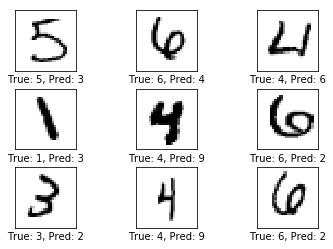

In [103]:
print_test_accuracy(show_example_errors=True)

# Performance after 1000 optimization iterations

After 1000 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 80%.

In [104]:
optimize(num_iterations=900) # We performed 100 iterations above.

Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02


Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22


Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:43
Time usage: 0:00:43
Time usage: 0:00:43


Accuracy on Test-Set: 93.9% (9388 / 10000)
Example errors:


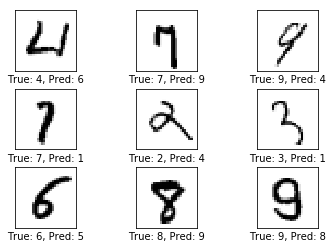

In [105]:
print_test_accuracy(show_example_errors=True)

# Performance after 10,000 optimization iterations

After 10,000 optimization iterations, the model has a classification accuracy on the test-set of about 99%.

In [106]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:00
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:01
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:02
Time usage: 0:00:03
Time usage: 0:00:03


Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:20
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:21
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:22
Time usage: 0:00:23
Time usage: 0:00:23
Time usage: 0:00:23
Time usage: 0:00:23
Time usage: 0:00:23
Time usage: 0:00:23
Time usage: 0:00:23
Time usage: 0:00:23


Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:40
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:41
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42
Time usage: 0:00:42


Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:00:59
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:00
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01
Time usage: 0:01:01


Time usage: 0:01:17
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:18
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:19
Time usage: 0:01:20
Time usage: 0:01:20
Time usage: 0:01:20
Time usage: 0:01:20
Time usage: 0:01:20


Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:36
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:37
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38
Time usage: 0:01:38


Time usage: 0:01:54
Time usage: 0:01:54
Time usage: 0:01:54
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:55
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:56
Time usage: 0:01:57
Time usage: 0:01:57
Time usage: 0:01:57
Time usage: 0:01:57


Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:13
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:14
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15
Time usage: 0:02:15


Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:32
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:33
Time usage: 0:02:34
Time usage: 0:02:34
Time usage: 0:02:34
Time usage: 0:02:34
Time usage: 0:02:34
Time usage: 0:02:34
Time usage: 0:02:34
Time usage: 0:02:34
Time usage: 0:02:34


Time usage: 0:02:50
Time usage: 0:02:50
Time usage: 0:02:50
Time usage: 0:02:50
Time usage: 0:02:50
Time usage: 0:02:50
Time usage: 0:02:50
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:51
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52
Time usage: 0:02:52


Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:09
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:10
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11
Time usage: 0:03:11


Time usage: 0:03:28
Time usage: 0:03:28
Time usage: 0:03:28
Time usage: 0:03:28
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:29
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:30
Time usage: 0:03:31
Time usage: 0:03:31


Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:47
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:48
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49
Time usage: 0:03:49


Time usage: 0:04:05
Time usage: 0:04:05
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:06
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:07
Time usage: 0:04:08
Time usage: 0:04:08
Time usage: 0:04:08
Time usage: 0:04:08
Time usage: 0:04:08


Time usage: 0:04:24
Time usage: 0:04:24
Time usage: 0:04:24
Time usage: 0:04:24
Time usage: 0:04:24
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:25
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:26
Time usage: 0:04:27
Time usage: 0:04:27


Time usage: 0:04:43
Time usage: 0:04:43
Time usage: 0:04:43
Time usage: 0:04:43
Time usage: 0:04:43
Time usage: 0:04:43
Time usage: 0:04:43
Time usage: 0:04:43
Time usage: 0:04:43
Time usage: 0:04:43
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:44
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45
Time usage: 0:04:45


Time usage: 0:05:01
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:02
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:03
Time usage: 0:05:04
Time usage: 0:05:04
Time usage: 0:05:04
Time usage: 0:05:04
Time usage: 0:05:04
Time usage: 0:05:04


Time usage: 0:05:20
Time usage: 0:05:20
Time usage: 0:05:20
Time usage: 0:05:20
Time usage: 0:05:20
Time usage: 0:05:20
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:21
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22
Time usage: 0:05:22


Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:39
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:40
Time usage: 0:05:41
Time usage: 0:05:41
Time usage: 0:05:41
Time usage: 0:05:41
Time usage: 0:05:41
Time usage: 0:05:41
Time usage: 0:05:41
Time usage: 0:05:41
Time usage: 0:05:41
Time usage: 0:05:41
Time usage: 0:05:41


Time usage: 0:05:57
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:58
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:05:59
Time usage: 0:06:00
Time usage: 0:06:00
Time usage: 0:06:00
Time usage: 0:06:00
Time usage: 0:06:00
Time usage: 0:06:00


Time usage: 0:06:16
Time usage: 0:06:16
Time usage: 0:06:16
Time usage: 0:06:16
Time usage: 0:06:16
Time usage: 0:06:16
Time usage: 0:06:16
Time usage: 0:06:16
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:17
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18
Time usage: 0:06:18


Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:35
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:36
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37
Time usage: 0:06:37


Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:54
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:55
Time usage: 0:06:56
Time usage: 0:06:56
Time usage: 0:06:56
Time usage: 0:06:56
Time usage: 0:06:56
Time usage: 0:06:56
Time usage: 0:06:56


Accuracy on Test-Set: 98.8% (9879 / 10000)
Example errors:


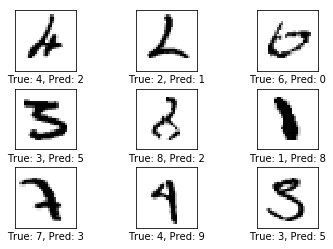

Example correct


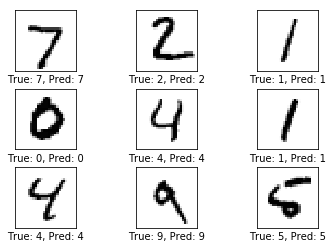

Confusion Matrix:
[[ 973    0    1    0    0    1    2    1    2    0]
 [   0 1126    3    0    1    0    1    2    2    0]
 [   1    1 1028    0    0    0    0    1    1    0]
 [   0    0    2  990    0   13    0    2    2    1]
 [   0    0    1    0  974    0    1    3    0    3]
 [   1    0    0    1    0  888    1    1    0    0]
 [   7    2    0    1    1    6  941    0    0    0]
 [   0    1    6    1    0    0    0 1014    2    4]
 [   5    0    5    2    1    3    0    1  955    2]
 [   3    3    1    1    5    4    0    2    0  990]]


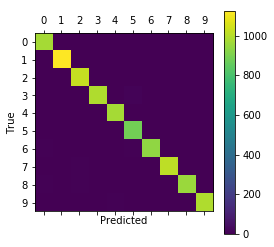

In [121]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True,
                    show_example_correct=True)

# Visualization of Weights and Layers

We can visualize the weights of the convolutional filters and the resulting output images in order to understand how a CNN can recognize handwritten digits.

### Helper-function for plotting convolutional weights

In [122]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are Tensorflow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [123]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Input Images

### Helper-function for plotting an image

In [124]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

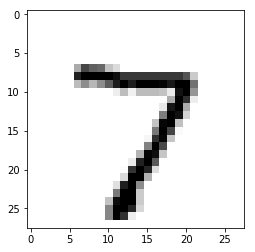

In [125]:
image1 = data.test.images[0]
plot_image(image1)

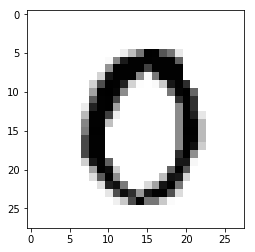

In [126]:
image2 = data.test.images[13]
plot_image(image2)

# Plotting Convolution Layer 1
Now plot the filter-weights for the first convolutional layer.
Note that positive weights are red and negative weights are blue.

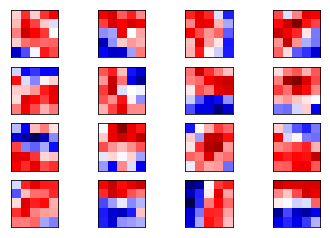

In [127]:
plot_conv_weights(weights=weights_conv1)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are down-sampled to 14 x 14 pixels which is half the resolution of the original input image.

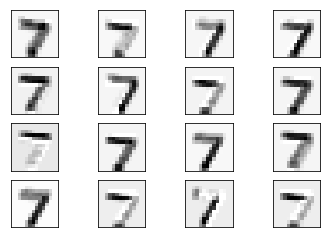

In [128]:
plot_conv_layer(layer=layer_conv1, image=image1)

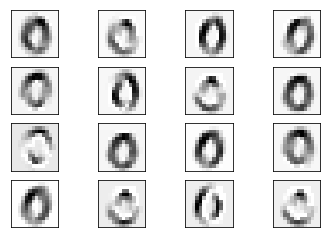

In [129]:
plot_conv_layer(layer=layer_conv1, image=image2)

It is difficult to see from these images what the purpose of the convolutional filters might be. It appears that they have merely created several variations of the input image, as if light was shining from different angles and casting shadows in the image.

# Convolution Layer 2
Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

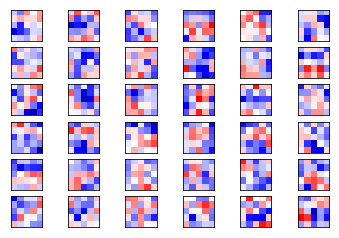

In [133]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel.

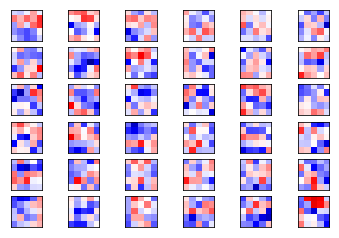

In [134]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled yet again to 7 x 7 pixels which is half the resolution of the images from the first conv-layer.

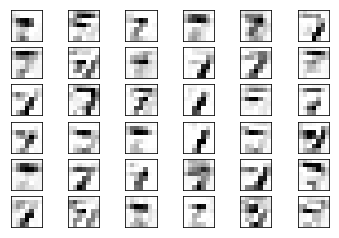

In [135]:
plot_conv_layer(layer=layer_conv2, image=image1)

And these are the results of applying the filter-weights to the second image.

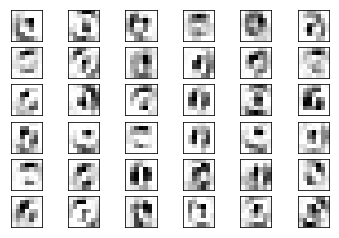

In [136]:
plot_conv_layer(layer=layer_conv2, image=image2)

From these images, it looks like the second convolutional layer might detect lines and patterns in the input images, which are less sensitive to local variations in the original input images.

These images are then flattened and input to the fully-connected layer, but that is not shown here.

# Terminate the Tensorflow session

We are done using Tensoeflow, so we can close the session in order to release its resources.

In [138]:
session.close()

This notebook was made possible by Siraj Raval's LIVE [video](https://www.youtube.com/watch?v=APmF6qE3Vjc&index=12&list=PL2-dafEMk2A7YdKv4XfKpfbTH5z6rEEj3) on classifying images using Tensorflow and [Hvass-Labs](http://www.hvass-labs.org/)